# Sensor-Space Analysis

In [1]:
### Importing packages

# 1. Core

import io
import pickle
from copy import copy
from collections import OrderedDict
import requests
import pathlib
import glob, os
import itertools

# 2. Data Science

import numpy as np
import pandas as pd
import scipy

# 3. Visualization

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

# 4. Brain Core

import mne
import hypyp
from mne.preprocessing import (ICA, corrmap)
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

### 1. Defining functions for preparing the data

In [2]:
### Defining a function for splitting the 25-s complex signal into 3-s segments for later use

def segment_complex_signal(complex_signal, pair_n, condition, dict_with_bad_epochs):
    complex_signal_no_baseline = complex_signal[:,:,:,:,513:] ### not including sample 0
    all_short_epochs_list = []
    for i in range(0,8):
        n_samples = 256 * 3 ### corresponds to 3-second segments
        short_epoch = complex_signal_no_baseline[:,:,:,:,n_samples*i:n_samples*(i+1)]
        all_short_epochs_list.append(short_epoch)
    complex_signal_short_epochs = np.concatenate(([i for i in all_short_epochs_list]),axis=1)
    
    # Removing bad epochs
    
    bad_epochs = dict_with_bad_epochs[pair_n + '_' + condition]
    s1 = np.delete(complex_signal_short_epochs[0], obj = bad_epochs, axis = 0) ### for subject a
    s2 = np.delete(complex_signal_short_epochs[1], obj = bad_epochs, axis = 0) ### for subject b
    all_s_complex_signal_short_epochs = np.stack((s1,s2), axis=0)

    print(f"The shape of the matrix with all epochs: {complex_signal_short_epochs.shape}.")
    print(f"The shape of the matrix without bad epochs: {all_s_complex_signal_short_epochs.shape}.")

    return(all_s_complex_signal_short_epochs)


### Defining a segmenting function for cutting original epochs into 3 sec

def segment_epochs(full_epochs, condition):
    epochs_list = []
    x = 0
    k = 0 ### a time shifter to make sure all shorter epochs have the same times
    for i in range(0,8):
        shorter_epochs = full_epochs[condition].crop(tmin=x,tmax=x+3,include_tmax=False)
        shorter_epochs.shift_time(k, relative=True)
        epochs_list.append(shorter_epochs)
        k = -x-3
        x = x+3
    conc_object = mne.concatenate_epochs(epochs_list, add_offset=True) ### concatenate
    final_object = mne.EpochsArray(data = conc_object.get_data(), info = conc_object.info) ### resent indices
    return(final_object)

### 2. Calculating PLV values for symmetrical conditions: Control, Coupled, Individual

##### 2.1. Creating a dictionary with bad short epochs

In [386]:
# 1. Split original epochs into 3-s segments without saving (one data file by one).
# 2. Accumulate the indices of bad (full of artifacts) epochs.

In [34]:
bad_short_epochs = {}

In [376]:
pair_n = '003'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition = 'control'

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_ave_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_ave_epo.fif'), verbose=False)

xxx_a = segment_epochs(epochs_a, condition)
xxx_b = segment_epochs(epochs_b, condition)

Not setting metadata
128 matching events found
No baseline correction applied
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
128 matching events found
No baseline correction applied
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated


In [377]:
xxx_a.plot(n_epochs=4, n_channels = 64)

<MNEBrowseFigure size 1600x1370 with 4 Axes>

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [378]:
xxx_b.plot(n_epochs=4, n_channels = 64)

<MNEBrowseFigure size 1600x1370 with 4 Axes>

Dropped 9 epochs: 7, 11, 23, 27, 29, 39, 44, 45, 71
The following epochs were marked as bad and are dropped:
[7, 11, 23, 27, 29, 39, 44, 45, 71]
Channels marked as bad:
none


In [374]:
bad_short_epochs[pair_n + '_' + condition] = [70]

In [379]:
### Save the dictionary

with open('dict_with_short_bad_epochs_symmetrical.pickle', 'wb') as handle:
    pickle.dump(bad_short_epochs, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### 2.2. Following the pipeline to get the parameters

In [9]:
### Open the dictionary

with open('dict_with_short_bad_epochs_symmetrical.pickle', 'rb') as f:
    bad_short_epochs = pickle.load(f)

In [12]:
### Calculate PLV matrices & save

data = {}

pairs = ["003","004","005","007","008","009","010","011","012","013","014",
         "016","017","018","019","020","022","023","024","025","027"]

reference = ['ave','csd','rest']

conditions = ["individual", "coupled", "control"]

measure = 'plv'

all_eeg_chans = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3',
                 'FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1',
                 'P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz',
                 'CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8',
                 'FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8',
                 'CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2']

for pair_n in pairs:
    for ref in reference:
        for condition in conditions:
            # 0. Verbose
            print(f"\n{pair_n} {ref} {condition}.")
        
            # 1. Loading
            folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"
            epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_{ref}_epo.fif'), verbose=False)
            epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_{ref}_epo.fif'), verbose=False)

            # 2. Selecting only one condition
            epochs_a = epochs_a[condition]
            epochs_b = epochs_b[condition]

            # 3. Equalizing the number of epochs (NO NEED)
            # mne.epochs.equalize_epoch_counts([epochs_a, epochs_b])
        
            # 4. Putting two sets of epochs into one array
            data_inter = np.array([epochs_a.pick(picks=all_eeg_chans), epochs_b.pick(picks=all_eeg_chans)])
        
            # 5. Calculating the complex signal with Hilbert
            freq_bands = {'Theta':[4,7.5],
                      'Alpha-Low': [8, 11],
                      'Alpha-High': [11.5, 13],
                      'Alpha_Combined': [8,13],
                      'Beta':[14,30]}
        
            sampling_rate = 256
        
            complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate, freq_bands)
        
            # 6. Splitting the complex signal of 25-s epochs into 3-s segments
            short_epochs = segment_complex_signal(complex_signal = complex_signal, 
                                                  pair_n = pair_n, 
                                                  condition = condition, 
                                                  dict_with_bad_epochs = bad_short_epochs)
        
            # 7. Calculating synchrony value (PLV)
            result = analyses.compute_sync(short_epochs, mode = measure, epochs_average=True)

            # 8. Retrieving the inter-brain part of the matrix
            n_ch = 64
            theta, alpha_low, alpha_high, alpha_combined, beta = result[:, 0:n_ch, n_ch:2*n_ch]
        
            # 9. Putting the matrices into a dictionary
            data[pair_n+"_"+ref+"_"+condition+"_"+'theta'] = theta
            data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_low'] = alpha_low
            data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_high'] = alpha_high
            data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_combined'] = alpha_combined
            data[pair_n+"_"+ref+"_"+condition+"_"+'beta'] = beta
            
            # 10. Saving the dictionary
            with open('plv_symmetrical_conditions.pickle', 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # 11. Verbose_2
            print("Proceeding to the next pair.")


003 ave individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 5, 768).
Proceeding to the next pair

003 ave coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

003 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 116, 64, 5, 768).
Proceeding to the next pair

003 csd individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 5, 768).
Proceeding to the next pair

003 csd coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

003 csd control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad ep

Proceeding to the next pair

009 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 121, 64, 5, 768).
Proceeding to the next pair

009 csd individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 126, 64, 5, 768).
Proceeding to the next pair

009 csd coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

009 csd control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 121, 64, 5, 768).
Proceeding to the next pair

009 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 126, 64, 5, 768).
Proceeding to the next pair

009 rest coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shap

Proceeding to the next pair

014 csd coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

014 csd control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 122, 64, 5, 768).
Proceeding to the next pair

014 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

014 rest coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

014 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 122, 64, 5, 768).
Proceeding to the next pair

016 ave individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The sha

Proceeding to the next pair

020 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 124, 64, 5, 768).
Proceeding to the next pair

020 rest coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 5, 768).
Proceeding to the next pair

020 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 128, 64, 5, 768).
Proceeding to the next pair

022 ave individual.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 123, 64, 5, 768).
Proceeding to the next pair

022 ave coupled.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 5, 768).
Proceeding to the next pair

022 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The sha

Proceeding to the next pair

027 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 5, 768).
The shape of the matrix without bad epochs: (2, 119, 64, 5, 768).
Proceeding to the next pair


In [3]:
### Open the dictionary

with open('plv_symmetrical_conditions.pickle', 'rb') as d:
    data = pickle.load(d)

### 3. Calculating PLV values for asymmetric conditions: Leader-Follower, Actor-Observer

##### 3.1. Defining a specific function for calculating the complex signal in this case

In [3]:
### Defining the function

def segment_complex_signal_asymm(complex_signal, pair_n, condition_a, condition_b, dict_with_bad_epochs):
    
    ### conditon_a defines the condition in which the subject A is (e.g., leader)
    ### condition_b defines the complementary condition for the subject B (e.g., follower) 
    
    complex_signal_no_baseline = complex_signal[:,:,:,:,513:] ### not including sample 0
    all_short_epochs_list = []
    for i in range(0,8):
        n_samples = 256 * 3 ### corresponds to 3-second segments
        short_epoch = complex_signal_no_baseline[:,:,:,:,n_samples*i:n_samples*(i+1)]
        all_short_epochs_list.append(short_epoch)
    complex_signal_short_epochs = np.concatenate(([i for i in all_short_epochs_list]),axis=1)
    
    # Removing bad epochs
    
    bad_epochs = dict_with_bad_epochs[pair_n + '_' + condition_a + '-' + condition_b]
    s1 = np.delete(complex_signal_short_epochs[0], obj = bad_epochs, axis = 0) ### for subject a
    s2 = np.delete(complex_signal_short_epochs[1], obj = bad_epochs, axis = 0) ### for subject b
    all_s_complex_signal_short_epochs = np.stack((s1,s2), axis=0)

    print(f"The shape of the original matrix is {complex_signal_short_epochs.shape}.")
    print(f"The shape of the final matrix is {all_s_complex_signal_short_epochs.shape}.")

    return(all_s_complex_signal_short_epochs)

In [407]:
#bad_short_epochs_asymm = {}

In [31]:
### Open the dictionary

#with open('dict_with_short_bad_epochs_asymm.pickle', 'rb') as k:
    #bad_short_epochs_asymm = pickle.load(k)

In [228]:
pair_n = '003'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition_a = 'follower'
condition_b = 'leader'

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_ave_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_ave_epo.fif'), verbose=False)

xxx_a = segment_epochs(epochs_a, condition_a)
xxx_b = segment_epochs(epochs_b, condition_b)

Not setting metadata
64 matching events found
No baseline correction applied
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
64 matching events found
No baseline correction applied
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated


In [230]:
xxx_a.plot(n_epochs=4, n_channels = 64)

<MNEBrowseFigure size 1600x1372 with 4 Axes>

Dropped 1 epoch: 15
The following epochs were marked as bad and are dropped:
[15]
Channels marked as bad:
none


In [231]:
xxx_b.plot(n_epochs=4, n_channels = 64)

<MNEBrowseFigure size 1600x1372 with 4 Axes>

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [232]:
bad_short_epochs_asymm[pair_n + '_' + condition_a + '-' + condition_b] = [15]

In [32]:
bad_short_epochs_asymm

{'003_actor-observer': [],
 '004_actor-observer': [4, 10],
 '005_actor-observer': [3, 4, 10, 11, 49],
 '007_actor-observer': [13, 19],
 '008_actor-observer': [1, 27],
 '009_actor-observer': [7, 62],
 '010_actor-observer': [19],
 '011_actor-observer': [5],
 '012_actor-observer': [8, 14, 16, 25, 33, 38, 39],
 '013_actor-observer': [],
 '014_actor-observer': [25],
 '016_actor-observer': [2],
 '017_actor-observer': [21],
 '018_actor-observer': [10, 13, 23, 27, 33],
 '019_actor-observer': [7],
 '020_actor-observer': [1, 13, 15, 21, 33],
 '022_actor-observer': [6, 14],
 '023_actor-observer': [6, 14],
 '024_actor-observer': [2, 6],
 '025_actor-observer': [0],
 '027_actor-observer': [],
 '003_observer-actor': [],
 '004_observer-actor': [],
 '005_observer-actor': [],
 '007_observer-actor': [4, 5],
 '008_observer-actor': [5, 19, 26, 48],
 '009_observer-actor': [],
 '010_observer-actor': [2, 3],
 '011_observer-actor': [],
 '012_observer-actor': [22],
 '013_observer-actor': [8],
 '014_observer-act

In [234]:
### Save the asymmetric dictionary

#with open('dict_with_short_bad_epochs_asymm.pickle', 'wb') as handle:
    #pickle.dump(bad_short_epochs_asymm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
### Asymmetric: Calculate PLV matrices & save

data_asymm = {}

pairs = ["003","004","005","007","008","009","010","011","012","013","014",
         "016","017","018","019","020","022","023","024","025","027"]

reference = ['ave','csd','rest']

conditions_asymm = ["actor-observer",
                    "leader-follower"]

measure = 'plv'

all_eeg_chans = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3',
                 'FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1',
                 'P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz',
                 'CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8',
                 'FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8',
                 'CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2']

for pair_n in pairs:
    for ref in reference:
        for condition in conditions_asymm:
            # 0. Verbose
            print(f"\n{pair_n} {ref} {condition}.")
        
            # 1. Loading
            folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"
            epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_{ref}_epo.fif'), verbose=False)
            epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_{ref}_epo.fif'), verbose=False)

            # 2. Selecting only one condition
            
            if condition == "actor-observer":
                condition_a = 'actor'
                condition_b = 'observer'
            elif condition == "leader-follower":
                condition_a = 'leader'
                condition_b = 'follower'
            
            ### One way
            
            epochs_a_1 = epochs_a[condition_a] #leader
            epochs_b_1 = epochs_b[condition_b] #follower
        
            data_inter_1 = np.array([epochs_a_1.pick(picks=all_eeg_chans), epochs_b_1.pick(picks=all_eeg_chans)])
        
            # ~ Calculating the complex signal with Hilbert
            freq_bands = {'Theta':[4,7.5],
                      'Alpha-Low': [8, 11],
                      'Alpha-High': [11.5, 13],
                      'Alpha_Combined': [8,13],
                      'Beta':[14,30]}
        
            sampling_rate = 256
        
            complex_signal_1 = analyses.compute_freq_bands(data_inter_1, sampling_rate, freq_bands)
        
            # ~ Splitting the complex signal of 25-s epochs into 3-s segments
            short_epochs_1 = segment_complex_signal_asymm(complex_signal = complex_signal_1, 
                                                  pair_n = pair_n, 
                                                  condition_a = condition_a,
                                                  condition_b = condition_b,
                                                  dict_with_bad_epochs = bad_short_epochs_asymm)
            
            ### Another way
            
            epochs_a_2 = epochs_a[condition_b] #follower
            epochs_b_2 = epochs_b[condition_a] #leader
        
            data_inter_2 = np.array([epochs_a_2.pick(picks=all_eeg_chans), epochs_b_2.pick(picks=all_eeg_chans)])
        
            # ~ Calculating the complex signal with Hilbert
            freq_bands = {'Theta':[4,7.5],
                      'Alpha-Low': [8, 11],
                      'Alpha-High': [11.5, 13],
                      'Alpha_Combined': [8,13],
                      'Beta':[14,30]}
        
            sampling_rate = 256
        
            complex_signal_2 = analyses.compute_freq_bands(data_inter_2, sampling_rate, freq_bands)
        
            # ~ Splitting the complex signal of 25-s epochs into 3-s segments
            
            short_epochs_2 = segment_complex_signal_asymm(complex_signal = complex_signal_2, 
                                                  pair_n = pair_n, 
                                                  condition_a = condition_b,
                                                  condition_b = condition_a,
                                                  dict_with_bad_epochs = bad_short_epochs_asymm)
        
            ### Combining two ways
            
            short_epochs = np.concatenate((short_epochs_1, short_epochs_2), axis=1)
            
            
            # 7. Calculating synchrony value (PLV)
            result = analyses.compute_sync(short_epochs, mode = measure, epochs_average=True)

            # 8. Retrieving the inter-brain part of the matrix
            n_ch = 64
            theta, alpha_low, alpha_high, alpha_combined, beta = result[:, 0:n_ch, n_ch:2*n_ch]
        
            # 9. Putting the matrices into a dictionary
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'theta'] = theta
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_low'] = alpha_low
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_high'] = alpha_high
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_combined'] = alpha_combined
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'beta'] = beta
            
            # 10. Saving the dictionary
            with open('plv_asymm_conditions_new.pickle', 'wb') as handle:
                pickle.dump(data_asymm, handle, protocol=pickle.HIGHEST_PROTOCOL)


003 ave actor-observer.
The shape of the original matrix is (2, 32, 64, 5, 768).
The shape of the final matrix is (2, 32, 64, 5, 768).
The shape of the original matrix is (2, 48, 64, 5, 768).
The shape of the final matrix is (2, 48, 64, 5, 768).

003 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).

003 csd actor-observer.
The shape of the original matrix is (2, 32, 64, 5, 768).
The shape of the final matrix is (2, 32, 64, 5, 768).
The shape of the original matrix is (2, 48, 64, 5, 768).
The shape of the final matrix is (2, 48, 64, 5, 768).

003 csd leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).

003 rest 

The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).

009 rest actor-observer.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 62, 64, 5, 768).
The shape of the original matrix is (2, 56, 64, 5, 768).
The shape of the final matrix is (2, 56, 64, 5, 768).

009 rest leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).

010 ave actor-observer.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 56, 64, 5, 768).
The shape of the final matrix is (2, 54, 64, 5, 768).

010 ave leader-follower.
The shap

The shape of the original matrix is (2, 48, 64, 5, 768).
The shape of the final matrix is (2, 47, 64, 5, 768).

016 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 59, 64, 5, 768).

016 csd actor-observer.
The shape of the original matrix is (2, 24, 64, 5, 768).
The shape of the final matrix is (2, 23, 64, 5, 768).
The shape of the original matrix is (2, 48, 64, 5, 768).
The shape of the final matrix is (2, 47, 64, 5, 768).

016 csd leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 59, 64, 5, 768).

016 rest actor-observer.
The shape of the original matrix is (2, 24, 64, 5, 768).
The shape of the final matrix is (2, 23, 64, 5, 768).
The shape


022 rest actor-observer.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 62, 64, 5, 768).
The shape of the original matrix is (2, 48, 64, 5, 768).
The shape of the final matrix is (2, 45, 64, 5, 768).

022 rest leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 64, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 62, 64, 5, 768).

023 ave actor-observer.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 62, 64, 5, 768).
The shape of the original matrix is (2, 32, 64, 5, 768).
The shape of the final matrix is (2, 32, 64, 5, 768).

023 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 63, 64, 5, 768).
The shape of the original matrix is (2, 64, 64, 5, 768).
The shape of the final matrix is (2, 61, 64, 5, 768).

023 csd

### 4. Doing Cluster-Based Permutation Tests

### 4.1. PLV

In [47]:
### Loading the dictionary with symmetric conditions

with open('plv_symmetrical_conditions.pickle', 'rb') as s:
    plv_data_symmetric = pickle.load(s)
    
### Loading the dictionary with Asymmetric conditions 

with open('plv_asymm_conditions_new.pickle', 'rb') as a:
    plv_data_asym = pickle.load(a)
    
### Merging two dicts

plv_data = plv_data_symmetric | plv_data_asym

In [81]:
### Cluster-based Permutation Test for the Inter-Brain Connectivity:
### Defining functions

######## Info

### A. Input

#  data: values from different conditions or different groups to compare,
#  list of arrays (3d for time-frequency power or connectivity values)

### B. Output

# Stat_obs: statistic (T or F values according to the assignement of 'test') 
# observed for all variables, array of shape (n_tests,).

# clusters: boolean array with same shape as the input data, 
# True values indicating locations that are part of a cluster, array.

# cluster_p_values: 
# p-value for each cluster, array.

# H0: max cluster level stats observed under permutation, 
# array of shape (n_permutations,).

# Stat_obs_plot: statistical values above alpha threshold, 
# to plot significant sensors, array of shape (n_tests,).

########

def perm_test(group1,group2):
    
    result = stats.statscluster(
    
        data=[group1, group2],
              test = 'rel ttest',      # repeated-samples t-test 
              factor_level = None,     # this is for ANOVA
              ch_con_freq=None,        # a priori connectivity
              tail=0,                  # both sides of the distribution
              n_permutations=5000,
              alpha=2.086              # corresponds to two-tails' 0.05 significance level 
                                       # with 20 degress of freedom (21 pair - 1)
                        )
    return(result)


def custom_permutation_test(dict_with_matrices,ref,freq,cond_a,cond_b):
    group1 = np.array([y for (x,y) in dict_with_matrices.items() if f'_{ref}_{cond_a}_{freq}' in x])
    group2 = np.array([b for (a,b) in dict_with_matrices.items() if f'_{ref}_{cond_b}_{freq}' in a])
    
    result = perm_test(group1,group2)
    
    return(np.array(result,dtype=object))

In [51]:
### Permutting

plv_res_perm = {}

ref_list = ['ave','csd','rest']
freq_list = ['theta','alpha_low','alpha_high','alpha_combined','beta']


for ref in ref_list:
    for freq in freq_list:
        
        ### 1. Symmetric conditions
        plv_res_perm[f'{ref}_{freq}_coupled_vs_control'] = custom_permutation_test(plv_data,
                                                                                   ref,freq,
                                                                                   'coupled','control')
        plv_res_perm[f'{ref}_{freq}_coupled_vs_individual'] = custom_permutation_test(plv_data,
                                                                                      ref,freq,
                                                                                      'coupled','individual')
        plv_res_perm[f'{ref}_{freq}_control_vs_individual'] = custom_permutation_test(plv_data_symmetric,
                                                                                      ref,freq,
                                                                                      'control','individual')
        
        ### 2. Asymmetric conditions
        plv_res_perm[f'{ref}_{freq}_ao_vs_lf'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'leader-follower')
        
        ### 3. Actor-observer VS the rest
        plv_res_perm[f'{ref}_{freq}_ao_vs_control'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'control')
        plv_res_perm[f'{ref}_{freq}_ao_vs_coupled'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'coupled')
        plv_res_perm[f'{ref}_{freq}_ao_vs_individual'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'individual')
        
        ### 4. Leader-follower VS the rest
        plv_res_perm[f'{ref}_{freq}_lf_vs_control'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'control')
        plv_res_perm[f'{ref}_{freq}_lf_vs_coupled'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'coupled')
        plv_res_perm[f'{ref}_{freq}_lf_vs_individual'] = custom_permutation_test(plv_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'individual')

stat_fun(H1): min=-3.870089 max=4.070646
Running initial clustering …
Found 171 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.300037 max=4.394363
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.114640 max=5.150072
Running initial clustering …
Found 153 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.790002 max=3.223314
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.841303 max=3.238305
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.821509 max=3.282214
Running initial clustering …
Found 167 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.579295 max=4.202258
Running initial clustering …
Found 110 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.765373 max=5.403669
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.723279 max=4.440018
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.157106 max=4.691424
Running initial clustering …
Found 192 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.537311 max=4.452321
Running initial clustering …
Found 125 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.401242 max=5.671798
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.666724 max=4.176265
Running initial clustering …
Found 115 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.552384 max=4.955472
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.818113 max=4.084589
Running initial clustering …
Found 143 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.839496 max=5.867316
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.983371 max=5.677370
Running initial clustering …
Found 139 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.939131 max=4.065537
Running initial clustering …
Found 111 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.142184 max=3.528611
Running initial clustering …
Found 136 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.707750 max=4.050333
Running initial clustering …
Found 119 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.597567 max=3.543743
Running initial clustering …
Found 131 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.157264 max=4.624389
Running initial clustering …
Found 130 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.825032 max=3.504487
Running initial clustering …
Found 137 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.854803 max=3.528310
Running initial clustering …
Found 110 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.984313 max=3.614554
Running initial clustering …
Found 138 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.258904 max=3.491201
Running initial clustering …
Found 156 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.256728 max=3.688724
Running initial clustering …
Found 181 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.827121 max=3.529420
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-6.758016 max=3.213407
Running initial clustering …
Found 155 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.888615 max=3.131097
Running initial clustering …
Found 178 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.622099 max=5.022638
Running initial clustering …
Found 139 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.595280 max=3.952084
Running initial clustering …
Found 144 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.089122 max=4.221291
Running initial clustering …
Found 100 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.739769 max=5.966933
Running initial clustering …
Found 170 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.913911 max=4.741004
Running initial clustering …
Found 190 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.241433 max=3.872705
Running initial clustering …
Found 147 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.206282 max=4.023908
Running initial clustering …
Found 135 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.003839 max=3.651924
Running initial clustering …
Found 136 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.894708 max=4.159790
Running initial clustering …
Found 177 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.899510 max=3.998828
Running initial clustering …
Found 143 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.565307 max=4.020177
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.392042 max=3.519516
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.167770 max=3.833277
Running initial clustering …
Found 153 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.645705 max=5.529003
Running initial clustering …
Found 175 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.644840 max=5.014770
Running initial clustering …
Found 135 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.739991 max=5.397714
Running initial clustering …
Found 169 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.024162 max=3.974173
Running initial clustering …
Found 149 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.512485 max=5.540190
Running initial clustering …
Found 174 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.384144 max=3.784247
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.693353 max=4.403340
Running initial clustering …
Found 195 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.192260 max=6.450216
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.251260 max=5.014732
Running initial clustering …
Found 182 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.248899 max=3.746947
Running initial clustering …
Found 142 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.883216 max=3.942692
Running initial clustering …
Found 177 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.967415 max=3.416954
Running initial clustering …
Found 182 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.489418 max=3.717571
Running initial clustering …
Found 181 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-6.248845 max=3.489027
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.413254 max=4.174335
Running initial clustering …
Found 170 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.040818 max=3.631717
Running initial clustering …
Found 146 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.694400 max=3.890984
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.240424 max=4.151023
Running initial clustering …
Found 178 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.636982 max=3.949772
Running initial clustering …
Found 169 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.830962 max=5.035445
Running initial clustering …
Found 148 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.843540 max=4.936011
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.646293 max=4.551241
Running initial clustering …
Found 166 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.488197 max=4.435522
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.073967 max=4.541537
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.130360 max=4.094649
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.779453 max=3.851595
Running initial clustering …
Found 150 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.857430 max=4.875178
Running initial clustering …
Found 155 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.567379 max=5.254455
Running initial clustering …
Found 147 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.540411 max=5.093283
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.622683 max=5.196921
Running initial clustering …
Found 142 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.340627 max=4.538935
Running initial clustering …
Found 179 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.414007 max=3.668168
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.966274 max=3.860242
Running initial clustering …
Found 183 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.834622 max=4.745662
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.509017 max=4.229858
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.257485 max=4.662530
Running initial clustering …
Found 170 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.447025 max=4.042084
Running initial clustering …
Found 174 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.812885 max=4.843638
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.536385 max=4.795594
Running initial clustering …
Found 197 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.215484 max=4.869390
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.634447 max=5.612019
Running initial clustering …
Found 198 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.303970 max=4.929760
Running initial clustering …
Found 193 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.040296 max=5.382944
Running initial clustering …
Found 204 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.204875 max=5.047387
Running initial clustering …
Found 167 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.514747 max=4.564535
Running initial clustering …
Found 165 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.701552 max=3.797339
Running initial clustering …
Found 184 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.499964 max=3.947613
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.823813 max=4.296713
Running initial clustering …
Found 147 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.896312 max=4.171951
Running initial clustering …
Found 191 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.989391 max=4.281947
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.269625 max=4.983864
Running initial clustering …
Found 148 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.641465 max=4.266575
Running initial clustering …
Found 153 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.298782 max=4.212117
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.672521 max=4.223900
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.572802 max=3.750382
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.795858 max=4.129980
Running initial clustering …
Found 170 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.651465 max=3.691934
Running initial clustering …
Found 165 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.632111 max=5.152989
Running initial clustering …
Found 149 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.968331 max=7.053205
Running initial clustering …
Found 145 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.122255 max=4.709002
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.903414 max=4.018268
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.906488 max=3.979314
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.873685 max=3.302200
Running initial clustering …
Found 137 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.111198 max=4.441063
Running initial clustering …
Found 115 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.801119 max=3.852263
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.653901 max=3.402534
Running initial clustering …
Found 119 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.989793 max=5.242554
Running initial clustering …
Found 189 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.618406 max=3.929575
Running initial clustering …
Found 106 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.319364 max=4.268121
Running initial clustering …
Found 136 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.118090 max=5.514927
Running initial clustering …
Found 153 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.825481 max=5.234912
Running initial clustering …
Found 149 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.801870 max=4.649678
Running initial clustering …
Found 154 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.983713 max=4.227752
Running initial clustering …
Found 110 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.177395 max=4.873020
Running initial clustering …
Found 171 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.928886 max=3.542047
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.419768 max=3.130336
Running initial clustering …
Found 131 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.322213 max=3.876177
Running initial clustering …
Found 148 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.258750 max=4.748359
Running initial clustering …
Found 142 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.665979 max=4.126564
Running initial clustering …
Found 121 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.045229 max=3.843600
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.610551 max=3.289063
Running initial clustering …
Found 104 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.145413 max=4.973640
Running initial clustering …
Found 142 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.854039 max=3.673401
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.361485 max=3.457995
Running initial clustering …
Found 165 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.665715 max=3.540255
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.607467 max=3.316169
Running initial clustering …
Found 117 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.142466 max=3.071442
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.936446 max=4.461570
Running initial clustering …
Found 132 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.860761 max=3.887523
Running initial clustering …
Found 122 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.210086 max=4.154242
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.532989 max=5.142024
Running initial clustering …
Found 193 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.928587 max=4.823374
Running initial clustering …
Found 187 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.259922 max=4.115565
Running initial clustering …
Found 125 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.930213 max=4.696002
Running initial clustering …
Found 133 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.529034 max=3.622799
Running initial clustering …
Found 131 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.200521 max=3.458413
Running initial clustering …
Found 177 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.784460 max=3.048793
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.506054 max=4.006479
Running initial clustering …
Found 148 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.559222 max=3.345886
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.528629 max=4.054243
Running initial clustering …
Found 130 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.126179 max=4.329608
Running initial clustering …
Found 171 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.906499 max=4.665110
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.795011 max=6.076017
Running initial clustering …
Found 188 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.134494 max=5.293748
Running initial clustering …
Found 138 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.528033 max=6.334881
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.742689 max=3.691548
Running initial clustering …
Found 121 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.523125 max=4.995244
Running initial clustering …
Found 179 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

<b>Although the immediate output above shows that the number of permutations is 0, the saved data is correct.<br>These zeros appear after reloading the script.</b>

In [52]:
### Saving the dictionary

#with open('plv_results_permutation.pickle', 'wb') as handle:
    #pickle.dump(plv_res_perm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
### Loading it back

with open('plv_results_permutation.pickle', 'rb') as a:
    plv_res_perm = pickle.load(a)

In [13]:
### Defining functions for data presentations

def freq_fun(string):
    ff = ['theta','beta','alpha_combined','alpha_low','alpha_high']
    for f in ff:
        if f in string:
            result = f
    return(result)

def ref_fun(string):
    rr = ['ave','csd','rest']
    for r in rr:
        if r in string:
            result = r
    return(result)

def cond_fun(string):
    new_string = string.split('_vs_')
    cc = ['coupled','control','individual','lf','ao']
    for c in cc:
        if c in new_string[0]:
            cond1 = c
        if c in new_string[1]:
            cond2 = c
    return(cond1,cond2)

In [14]:
### Presenting a clear data frame

key_list = []
n_list = []
index_list = []
sign_list = []

freq_list = []
ref_list = []
cond1_list = []
cond2_list = []

dict_for_plots_plv = {}

for key in plv_res_perm.keys():
    
    clusters = plv_res_perm[key][1]
    cluster_p_values = plv_res_perm[key][2]
    Stat_obs = plv_res_perm[key][0]
    
    n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
    if n_significant_clusters > 0:
        freq_list.append(freq_fun(key))
        ref_list.append(ref_fun(key))
        cond1_list.append(cond_fun(key)[0])
        cond2_list.append(cond_fun(key)[1])
        
        cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
        key_list.append(key)
        n_list.append(n_significant_clusters)
        index_list.append(cluster_indices)
        
        sign_sublist = []
        for cluster_p in cluster_p_values:
            if cluster_p <= 0.05:
                sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                Stat_values = sensors_plot*Stat_obs
                dict_for_plots_plv[key] = Stat_values
                
                cluster_values = []
                for e_out in range(0,64):
                    for e_in in range(0,64):
                        if Stat_values[e_out][e_in] != 0:
                            cluster_values.append(Stat_values[e_out][e_in])
            
                if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                    sign_sublist.append('negative')
                else:
                    sign_sublist.append('positive')
        sign_list.append(sign_sublist)
                
cluster_data_plv = pd.DataFrame({
    'Key':key_list,
    'Condition_1': cond1_list,
    'Condition_2': cond2_list,
    'Frequency': freq_list,
    'Reference': ref_list,
    'N_signif._clusters': n_list,
    'Signs': sign_list,
    'Indices': index_list
})

In [16]:
cluster_data_plv = cluster_data_plv.sort_values('Reference', 
                                        ascending=True, ignore_index = True)
cluster_data_plv.loc[cluster_data_plv['Frequency'].isin(['theta','beta','alpha_combined'])].replace('alpha_combined','alpha')



,Key,Condition_1,Condition_2,Frequency,Reference,N_signif._clusters,Signs,Indices
0,ave_theta_lf_vs_control,lf,control,theta,ave,1,[positive],[62]
4,ave_alpha_combined_ao_vs_lf,ao,lf,alpha,ave,4,"[positive, positive, positive, positive]","[1, 47, 80, 131]"
5,ave_alpha_combined_lf_vs_coupled,lf,coupled,alpha,ave,2,"[negative, negative]","[61, 101]"
6,ave_alpha_combined_lf_vs_individual,lf,individual,alpha,ave,2,"[negative, negative]","[72, 124]"
7,csd_alpha_combined_ao_vs_control,ao,control,alpha,csd,1,[positive],[159]
9,csd_beta_lf_vs_control,lf,control,beta,csd,1,[negative],[113]
10,csd_beta_coupled_vs_control,coupled,control,beta,csd,2,"[negative, negative]","[119, 120]"
12,rest_alpha_combined_ao_vs_lf,ao,lf,alpha,rest,2,"[positive, positive]","[1, 153]"
13,rest_theta_lf_vs_control,lf,control,theta,rest,1,[positive],[61]
14,rest_theta_lf_vs_individual,lf,individual,theta,rest,2,"[positive, positive]","[41, 144]"


CSD – Coupled vs Control (Beta)


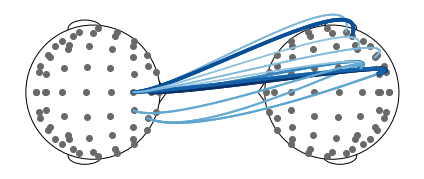

CSD – Coupled vs Individual (Alpha High)


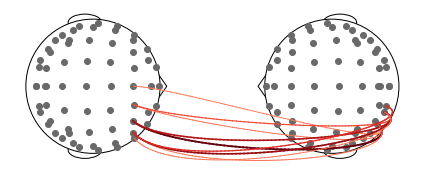

CSD – Actor-Observer vs Control (Alpha Combined)


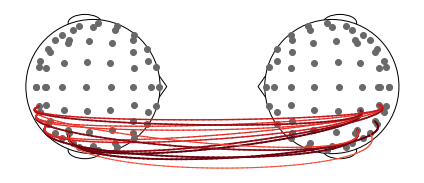

CSD – Leader-Follower vs Control (Beta)


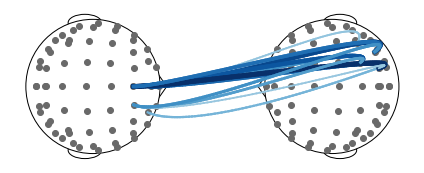

In [250]:
### Visualizing for CSD

pair_n = '003'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition = 'coupled'

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_csd_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_csd_epo.fif'), verbose=False)


print('CSD – Coupled vs Control (Beta)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_beta_coupled_vs_control'], 
                         threshold=1, steps=100, lab=False)

print('CSD – Coupled vs Individual (Alpha High)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_alpha_high_coupled_vs_individual'], 
                         threshold=1, steps=100, lab=False)

print('CSD – Actor-Observer vs Control (Alpha Combined)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_alpha_combined_ao_vs_control'], 
                         threshold=1, steps=100, lab=False)

print('CSD – Leader-Follower vs Control (Beta)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_beta_lf_vs_control'], 
                         threshold=1, steps=100, lab=False)

plt.show()

### 4.2. Circular Correlation Coefficient

In [82]:
### Defining the functions

import numpy as np
from scipy.stats import norm

def circ_mean(alpha):
    return np.angle(np.sum(np.exp(1j * alpha)))

def circ_corrcc_uniform(alpha1, alpha2):
    x_sin = np.sin(alpha1 - circ_mean(alpha1))
    y_sin = np.sin(alpha2 - circ_mean(alpha2))
    r_minus = np.abs(np.sum(np.exp((alpha1-alpha2) * 1j)))
    r_plus  = np.abs(np.sum(np.exp((alpha1+alpha2) * 1j)))
    num = (r_minus - r_plus)
    den = 2*np.sqrt(np.sum(x_sin**2) * np.sum(y_sin**2))
    rho = num / den
    return(rho)

def ccorr_connectivity(complex_signal):
    n_epoch, n_ch, n_freq, n_samp = complex_signal.shape[1], complex_signal.shape[2], \
                                    complex_signal.shape[3], complex_signal.shape[4]

    complex_signal_new = complex_signal.transpose((1, 3, 0, 2, 4)).reshape(n_epoch, n_freq, 2 * n_ch, n_samp)
    phase = np.angle(complex_signal_new)
    
    starting_matrix = np.zeros((n_epoch,n_freq,128,128))

    for epoch in range(n_epoch):
        for frequency in range(n_freq):
            for channel_1 in range(0,64):
                for channel_2 in range(64,128):
                    starting_matrix[epoch][frequency][channel_1][channel_2] = circ_corrcc_uniform(
                        phase[epoch][frequency][channel_1],
                        phase[epoch][frequency][channel_2])
                
    ### averaging across epochs
    starting_matrix_swapped = starting_matrix.swapaxes(0, 1)
    matrix = np.nanmean(starting_matrix_swapped, axis=1)[:,0:64,64:128]
    return(matrix)

In [83]:
### Open the dictionaries with bad epochs

with open('dict_with_short_bad_epochs_symmetrical.pickle', 'rb') as f:
    bad_short_epochs = pickle.load(f)
    
with open('dict_with_short_bad_epochs_asymm.pickle', 'rb') as k:
    bad_short_epochs_asymm = pickle.load(k)

In [84]:
### Loop over all symmetric conditions — ONLY CSD REFERENCE

### Calculate Envelope matrices & save

data = {}

pairs = ["003","004","005","007","008","009","010","011","012","013","014",
         "016","017","018","019","020","022","023","024","025","027"]

reference = ['rest','ave']

conditions = ["individual", "coupled", "control"]

measure = 'ccorr'

all_eeg_chans = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3',
                 'FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1',
                 'P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz',
                 'CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8',
                 'FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8',
                 'CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2']

for pair_n in pairs:
    for ref in reference:
        for condition in conditions:
            # 0. Verbose
            print(f"\n{pair_n} {ref} {condition}.")
        
            # 1. Loading
            folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"
            epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_{ref}_epo.fif'), verbose=False)
            epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_{ref}_epo.fif'), verbose=False)

            # 2. Selecting only one condition
            epochs_a = epochs_a[condition]
            epochs_b = epochs_b[condition]

            # 3. Equalizing the number of epochs (NO NEED)
            # mne.epochs.equalize_epoch_counts([epochs_a, epochs_b])
        
            # 4. Putting two sets of epochs into one array
            data_inter = np.array([epochs_a.pick(picks=all_eeg_chans), epochs_b.pick(picks=all_eeg_chans)])
        
            # 5. Calculating the complex signal with Hilbert
            freq_bands = {'Theta':[4,7.5],
                      #'Alpha-Low': [8, 11],
                      #'Alpha-High': [11.5, 13],
                      'Alpha_Combined': [8,13],
                      'Beta':[14,30]}
        
            sampling_rate = 256
        
            complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate, freq_bands)
        
            # 6. Splitting the complex signal of 25-s epochs into 3-s segments
            short_epochs = segment_complex_signal(complex_signal = complex_signal, 
                                                  pair_n = pair_n, 
                                                  condition = condition, 
                                                  dict_with_bad_epochs = bad_short_epochs)
        
            # 7. Calculating synchrony value (CCORR)
            theta, alpha_combined, beta = ccorr_connectivity(short_epochs)
        
            # 9. Putting the matrices into a dictionary
            data[pair_n+"_"+ref+"_"+condition+"_"+'theta'] = theta
            #data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_low'] = alpha_low
            #data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_high'] = alpha_high
            data[pair_n+"_"+ref+"_"+condition+"_"+'alpha_combined'] = alpha_combined
            data[pair_n+"_"+ref+"_"+condition+"_"+'beta'] = beta
            
            # 10. Saving the dictionary
            with open('ccorr_symmetric_conditions_1.pickle', 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # 11. Verbose_2
            #print("Proceeding to the next pair.")


003 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 3, 768).

003 rest coupled.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 3, 768).

003 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 116, 64, 3, 768).

003 ave individual.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 3, 768).

003 ave coupled.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 3, 768).

003 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 116, 64, 3, 768).

004 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix 


013 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 3, 768).

013 ave individual.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 124, 64, 3, 768).

013 ave coupled.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 124, 64, 3, 768).

013 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 125, 64, 3, 768).

014 rest individual.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 3, 768).

014 rest coupled.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 127, 64, 3, 768).

014 rest control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix wit


024 ave coupled.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 121, 64, 3, 768).

024 ave control.
The shape of the matrix with all epochs: (2, 128, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 123, 64, 3, 768).

025 rest individual.
The shape of the matrix with all epochs: (2, 80, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 77, 64, 3, 768).

025 rest coupled.
The shape of the matrix with all epochs: (2, 88, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 85, 64, 3, 768).

025 rest control.
The shape of the matrix with all epochs: (2, 80, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 80, 64, 3, 768).

025 ave individual.
The shape of the matrix with all epochs: (2, 80, 64, 3, 768).
The shape of the matrix without bad epochs: (2, 77, 64, 3, 768).

025 ave coupled.
The shape of the matrix with all epochs: (2, 88, 64, 3, 768).
The shape of the matrix without bad e

In [85]:
### Asymmetric: Calculate CCORR matrices & save

data_asymm = {}

pairs = ["003","004","005","007","008","009","010","011","012","013","014",
         "016","017","018","019","020","022","023","024","025","027"]

reference = ['rest','ave']

conditions_asymm = ["actor-observer",
                    "leader-follower"]

measure = 'ccorr'

all_eeg_chans = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3',
                 'FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1',
                 'P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz',
                 'CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8',
                 'FT8','FC6','FC4','FC2','FCz','Cz','C2','C4','C6','T8','TP8',
                 'CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2']

for pair_n in pairs:
    for ref in reference:
        for condition in conditions_asymm:
            # 0. Verbose
            print(f"\n{pair_n} {ref} {condition}.")
        
            # 1. Loading
            folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"
            epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_{ref}_epo.fif'), verbose=False)
            epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_{ref}_epo.fif'), verbose=False)

            # 2. Selecting only one condition
            
            if condition == "actor-observer":
                condition_a = 'actor'
                condition_b = 'observer'
            elif condition == "leader-follower":
                condition_a = 'leader'
                condition_b = 'follower'
            
            ### One way
            
            epochs_a_1 = epochs_a[condition_a] #leader
            epochs_b_1 = epochs_b[condition_b] #follower
        
            data_inter_1 = np.array([epochs_a_1.pick(picks=all_eeg_chans), epochs_b_1.pick(picks=all_eeg_chans)])
        
            # ~ Calculating the complex signal with Hilbert
            freq_bands = {'Theta':[4,7.5],
                      #'Alpha-Low': [8, 11],
                      #'Alpha-High': [11.5, 13],
                      'Alpha_Combined': [8,13],
                      'Beta':[14,30]}
        
            sampling_rate = 256
        
            complex_signal_1 = analyses.compute_freq_bands(data_inter_1, sampling_rate, freq_bands)
        
            # ~ Splitting the complex signal of 25-s epochs into 3-s segments
            short_epochs_1 = segment_complex_signal_asymm(complex_signal = complex_signal_1, 
                                                  pair_n = pair_n, 
                                                  condition_a = condition_a,
                                                  condition_b = condition_b,
                                                  dict_with_bad_epochs = bad_short_epochs_asymm)
            
            ### Another way
            
            epochs_a_2 = epochs_a[condition_b] #follower
            epochs_b_2 = epochs_b[condition_a] #leader
        
            data_inter_2 = np.array([epochs_a_2.pick(picks=all_eeg_chans), epochs_b_2.pick(picks=all_eeg_chans)])
        
            # ~ Calculating the complex signal with Hilbert
        
            complex_signal_2 = analyses.compute_freq_bands(data_inter_2, sampling_rate, freq_bands)
        
            # ~ Splitting the complex signal of 25-s epochs into 3-s segments
            
            short_epochs_2 = segment_complex_signal_asymm(complex_signal = complex_signal_2, 
                                                  pair_n = pair_n, 
                                                  condition_a = condition_b,
                                                  condition_b = condition_a,
                                                  dict_with_bad_epochs = bad_short_epochs_asymm)
        
            ### Combining two ways
            
            short_epochs = np.concatenate((short_epochs_1, short_epochs_2), axis=1)
            
            
            # 7. Calculating synchrony value (CCORR)
            theta, alpha_combined, beta = ccorr_connectivity(short_epochs)
        
            # 9. Putting the matrices into a dictionary
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'theta'] = theta
            #data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_low'] = alpha_low
            #data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_high'] = alpha_high
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'alpha_combined'] = alpha_combined
            data_asymm[pair_n+"_"+ref+"_"+condition+"_"+'beta'] = beta
            
            # 10. Saving the dictionary
            with open('ccorr_asymm_conditions_1.pickle', 'wb') as handle:
                pickle.dump(data_asymm, handle, protocol=pickle.HIGHEST_PROTOCOL)


003 rest actor-observer.
The shape of the original matrix is (2, 32, 64, 3, 768).
The shape of the final matrix is (2, 32, 64, 3, 768).
The shape of the original matrix is (2, 48, 64, 3, 768).
The shape of the final matrix is (2, 48, 64, 3, 768).

003 rest leader-follower.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 63, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 64, 64, 3, 768).

003 ave actor-observer.
The shape of the original matrix is (2, 32, 64, 3, 768).
The shape of the final matrix is (2, 32, 64, 3, 768).
The shape of the original matrix is (2, 48, 64, 3, 768).
The shape of the final matrix is (2, 48, 64, 3, 768).

003 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 63, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 64, 64, 3, 768).

004 res

The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 64, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 63, 64, 3, 768).

012 ave actor-observer.
The shape of the original matrix is (2, 48, 64, 3, 768).
The shape of the final matrix is (2, 41, 64, 3, 768).
The shape of the original matrix is (2, 48, 64, 3, 768).
The shape of the final matrix is (2, 47, 64, 3, 768).

012 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 64, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 63, 64, 3, 768).

013 rest actor-observer.
The shape of the original matrix is (2, 40, 64, 3, 768).
The shape of the final matrix is (2, 40, 64, 3, 768).
The shape of the original matrix is (2, 40, 64, 3, 768).
The shape of the final matrix is (2, 39, 64, 3, 768).

013 rest leader-follower.
The shap

The shape of the original matrix is (2, 48, 64, 3, 768).
The shape of the final matrix is (2, 45, 64, 3, 768).

022 ave leader-follower.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 64, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 62, 64, 3, 768).

023 rest actor-observer.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 62, 64, 3, 768).
The shape of the original matrix is (2, 32, 64, 3, 768).
The shape of the final matrix is (2, 32, 64, 3, 768).

023 rest leader-follower.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 63, 64, 3, 768).
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 61, 64, 3, 768).

023 ave actor-observer.
The shape of the original matrix is (2, 64, 64, 3, 768).
The shape of the final matrix is (2, 62, 64, 3, 768).
The shap

In [86]:
### Loading the dictionary with symmetric conditions

with open('ccorr_symmetric_conditions.pickle', 'rb') as s:
    ccorr_data_symmetric = pickle.load(s)
    
### Loading the dictionary with symmetric conditions (the rest)

with open('ccorr_symmetric_conditions_1.pickle', 'rb') as s:
    ccorr_data_symmetric_1 = pickle.load(s)
    
### Loading the dictionary with Asymmetric conditions 

with open('ccorr_asymm_conditions.pickle', 'rb') as a:
    ccorr_data_asym = pickle.load(a)
    
### Loading the dictionary with Asymmetric conditions 

with open('ccorr_asymm_conditions_1.pickle', 'rb') as a:
    ccorr_data_asym_1 = pickle.load(a)
    
### Merging two dicts

ccorr_data = ccorr_data_symmetric | ccorr_data_symmetric_1 | ccorr_data_asym | ccorr_data_asym_1

In [99]:
### Permutting

ccorr_res_perm = {}

ref_list = ['csd','ave','rest']
freq_list = ['theta','alpha_combined','beta']


for ref in ref_list:
    for freq in freq_list:
        
        ### 1. Symmetric conditions
        ccorr_res_perm[f'{ref}_{freq}_coupled_vs_control'] = custom_permutation_test(ccorr_data,
                                                                                   ref,freq,
                                                                                   'coupled','control')
        ccorr_res_perm[f'{ref}_{freq}_coupled_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                                      ref,freq,
                                                                                      'coupled','individual')
        ccorr_res_perm[f'{ref}_{freq}_control_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                                      ref,freq,
                                                                                      'control','individual')
        
        ### 2. Asymmetric conditions
        ccorr_res_perm[f'{ref}_{freq}_ao_vs_lf'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'leader-follower')
        
        ### 3. Actor-observer VS the rest
        ccorr_res_perm[f'{ref}_{freq}_ao_vs_control'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'control')
        ccorr_res_perm[f'{ref}_{freq}_ao_vs_coupled'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'coupled')
        ccorr_res_perm[f'{ref}_{freq}_ao_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'individual')
        
        ### 4. Leader-follower VS the rest
        ccorr_res_perm[f'{ref}_{freq}_lf_vs_control'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'control')
        ccorr_res_perm[f'{ref}_{freq}_lf_vs_coupled'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'coupled')
        ccorr_res_perm[f'{ref}_{freq}_lf_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'individual')

stat_fun(H1): min=-5.059967 max=6.642996
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.064313 max=5.215714
Running initial clustering …
Found 183 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.075122 max=4.254570
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.532819 max=3.444119
Running initial clustering …
Found 179 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.761892 max=3.657521
Running initial clustering …
Found 181 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-6.008046 max=3.995123
Running initial clustering …
Found 170 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-6.359255 max=3.576859
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.483482 max=4.773607
Running initial clustering …
Found 178 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.156913 max=3.618886
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.349503 max=3.952796
Running initial clustering …
Found 166 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.803923 max=4.649298
Running initial clustering …
Found 156 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.523977 max=4.558925
Running initial clustering …
Found 195 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.107067 max=4.843761
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.598360 max=5.710161
Running initial clustering …
Found 224 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.110919 max=5.143557
Running initial clustering …
Found 214 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.074479 max=5.784456
Running initial clustering …
Found 223 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.022609 max=5.037236
Running initial clustering …
Found 184 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.830558 max=4.219440
Running initial clustering …
Found 155 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.629205 max=4.032062
Running initial clustering …
Found 178 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.517792 max=3.682516
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.774526 max=4.320452
Running initial clustering …
Found 150 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.669600 max=4.499273
Running initial clustering …
Found 182 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.759487 max=4.052858
Running initial clustering …
Found 155 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.087092 max=4.471259
Running initial clustering …
Found 151 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.397877 max=4.109530
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.365306 max=3.978053
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.809863 max=4.035972
Running initial clustering …
Found 155 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.818899 max=3.660585
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.188295 max=3.740452
Running initial clustering …
Found 173 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.725475 max=3.853288
Running initial clustering …
Found 152 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.284324 max=4.187636
Running initial clustering …
Found 164 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.343669 max=4.198024
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.257200 max=5.324006
Running initial clustering …
Found 152 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.682330 max=2.993130
Running initial clustering …
Found 164 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.374758 max=3.520380
Running initial clustering …
Found 145 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.078021 max=3.191205
Running initial clustering …
Found 152 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.804578 max=4.227785
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.971831 max=5.287375
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.715067 max=4.677182
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.027122 max=4.848744
Running initial clustering …
Found 187 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.620459 max=4.717169
Running initial clustering …
Found 133 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.482729 max=4.008295
Running initial clustering …
Found 140 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.122369 max=4.235662
Running initial clustering …
Found 105 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.633447 max=6.358013
Running initial clustering …
Found 207 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.663095 max=4.749800
Running initial clustering …
Found 186 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.066842 max=4.207895
Running initial clustering …
Found 166 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.065176 max=4.248903
Running initial clustering …
Found 144 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.286269 max=3.497077
Running initial clustering …
Found 139 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.566445 max=4.165815
Running initial clustering …
Found 185 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.095357 max=3.794252
Running initial clustering …
Found 158 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.234567 max=3.879749
Running initial clustering …
Found 162 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.334098 max=3.919754
Running initial clustering …
Found 163 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.992994 max=3.804760
Running initial clustering …
Found 147 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.181231 max=5.408906
Running initial clustering …
Found 178 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.864489 max=5.092683
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.691598 max=5.499169
Running initial clustering …
Found 165 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.864153 max=4.212835
Running initial clustering …
Found 150 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.617010 max=5.206503
Running initial clustering …
Found 174 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.160968 max=3.419429
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.758525 max=4.400383
Running initial clustering …
Found 173 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.650217 max=4.873647
Running initial clustering …
Found 134 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.966185 max=7.493236
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.292924 max=5.128026
Running initial clustering …
Found 164 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.035140 max=3.889222
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.879890 max=4.161842
Running initial clustering …
Found 166 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.848513 max=3.353106
Running initial clustering …
Found 138 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.059372 max=4.686441
Running initial clustering …
Found 124 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.003730 max=3.874389
Running initial clustering …
Found 157 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.729371 max=3.371390
Running initial clustering …
Found 121 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.197034 max=5.306761
Running initial clustering …
Found 190 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.025401 max=4.301752
Running initial clustering …
Found 120 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.966468 max=3.885659
Running initial clustering …
Found 119 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.275251 max=3.899250
Running initial clustering …
Found 111 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.437024 max=5.377470
Running initial clustering …
Found 221 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.682417 max=5.101992
Running initial clustering …
Found 183 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.080215 max=4.290265
Running initial clustering …
Found 145 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.673421 max=4.990935
Running initial clustering …
Found 139 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.795690 max=3.638236
Running initial clustering …
Found 152 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.995933 max=3.649048
Running initial clustering …
Found 176 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.269324 max=3.013797
Running initial clustering …
Found 168 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.410197 max=3.990362
Running initial clustering …
Found 147 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.330711 max=3.720628
Running initial clustering …
Found 141 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.358744 max=4.194876
Running initial clustering …
Found 120 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.195170 max=4.286038
Running initial clustering …
Found 176 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.927974 max=4.577562
Running initial clustering …
Found 165 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.865403 max=5.427430
Running initial clustering …
Found 181 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.146241 max=4.618889
Running initial clustering …
Found 134 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.855492 max=6.862400
Running initial clustering …
Found 161 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.878856 max=3.632520
Running initial clustering …
Found 132 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.265367 max=5.157167
Running initial clustering …
Found 160 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

<b>Although the immediate output above shows that the number of permutations is 0, the saved data is correct.<br> These zeros appear after reloading the script.</b>

In [100]:
### Saving the dictionary

#with open('ccorr_results_permutation_1.pickle', 'wb') as handle:
    #pickle.dump(ccorr_res_perm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('ccorr_results_permutation_1.pickle', 'rb') as k:
    ccorr_res_perm = pickle.load(k)

In [21]:
### Presenting a clear data frame

key_list = []
n_list = []
index_list = []
sign_list = []

freq_list = []
ref_list = []
cond1_list = []
cond2_list = []

dict_for_plots = {}

for key in ccorr_res_perm.keys():
    
    clusters = ccorr_res_perm[key][1]
    cluster_p_values = ccorr_res_perm[key][2]
    Stat_obs = ccorr_res_perm[key][0]
    
    n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
    if n_significant_clusters > 0:
        freq_list.append(freq_fun(key))
        ref_list.append(ref_fun(key))
        cond1_list.append(cond_fun(key)[0])
        cond2_list.append(cond_fun(key)[1])
        
        cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
        key_list.append(key)
        n_list.append(n_significant_clusters)
        index_list.append(cluster_indices)
        
        sign_sublist = []
        for cluster_p in cluster_p_values:
            if cluster_p <= 0.05:
                sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                Stat_values = sensors_plot*Stat_obs
                dict_for_plots[key] = Stat_values
                
                cluster_values = []
                for e_out in range(0,64):
                    for e_in in range(0,64):
                        if Stat_values[e_out][e_in] != 0:
                            cluster_values.append(Stat_values[e_out][e_in])
            
                if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                    sign_sublist.append('negative')
                else:
                    sign_sublist.append('positive')
        sign_list.append(sign_sublist)
                
cluster_data_ccorr = pd.DataFrame({
    'Key':key_list,
    'Condition_1': cond1_list,
    'Condition_2': cond2_list,
    'Frequency': freq_list,
    'Reference': ref_list,
    'N_signif._clusters': n_list,
    'Signs': sign_list,
    'Indices': index_list
})

In [24]:
cluster_data_ccorr.sort_values('Reference', ascending=True, ignore_index = True).replace('alpha_combined','alpha')

,Key,Condition_1,Condition_2,Frequency,Reference,N_signif._clusters,Signs,Indices
0,ave_theta_lf_vs_control,lf,control,theta,ave,2,"[positive, positive]","[8, 62]"
1,ave_theta_lf_vs_individual,lf,individual,theta,ave,1,[positive],[1]
2,ave_alpha_combined_ao_vs_lf,ao,lf,alpha,ave,5,"[positive, positive, positive, positive, posit...","[2, 65, 104, 166, 167]"
3,ave_alpha_combined_lf_vs_coupled,lf,coupled,alpha,ave,3,"[negative, negative, negative]","[60, 104, 181]"
4,ave_alpha_combined_lf_vs_individual,lf,individual,alpha,ave,2,"[negative, negative]","[77, 127]"
5,csd_alpha_combined_ao_vs_control,ao,control,alpha,csd,1,[positive],[186]
6,csd_beta_lf_vs_control,lf,control,beta,csd,1,[negative],[119]
7,rest_theta_lf_vs_individual,lf,individual,theta,rest,1,[positive],[146]
8,rest_alpha_combined_ao_vs_lf,ao,lf,alpha,rest,2,"[positive, positive]","[2, 177]"
9,rest_alpha_combined_ao_vs_control,ao,control,alpha,rest,1,[positive],[38]


CCORR: CSD – Actor-Observer vs Control (Alpha, 8–13 Hz)


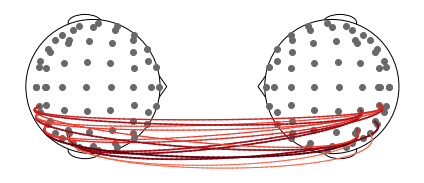

CCORR: CSD – Leader-Follower vs Control (Beta, 13.5–30 Hz)


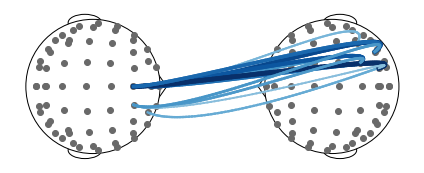

In [37]:
### Visualizing for CSD

pair_n = '005'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition = 'coupled'

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_csd_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_csd_epo.fif'), verbose=False)


print('CCORR: CSD – Actor-Observer vs Control (Alpha, 8–13 Hz)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_alpha_combined_ao_vs_control'], 
                         threshold=1, steps=100, lab=False)

print('CCORR: CSD – Leader-Follower vs Control (Beta, 13.5–30 Hz)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots['csd_beta_lf_vs_control'], 
                         threshold=1, steps=100, lab=False)

plt.show()

In [60]:
### Permutting

ccorr_res_perm_test = {}

ref_list = ['csd']
freq_list = ['theta','alpha_combined','beta']


for ref in ref_list:
    for freq in freq_list:
        
        ### 1. Symmetric conditions
        ccorr_res_perm_test[f'{ref}_{freq}_coupled_vs_control'] = custom_permutation_test(ccorr_data,
                                                                                   ref,freq,
                                                                                   'coupled','control')
        ccorr_res_perm_test[f'{ref}_{freq}_coupled_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                                      ref,freq,
                                                                                      'coupled','individual')
        ccorr_res_perm_test[f'{ref}_{freq}_control_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                                      ref,freq,
                                                                                      'control','individual')
        
        ### 2. Asymmetric conditions
        ccorr_res_perm_test[f'{ref}_{freq}_ao_vs_lf'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'leader-follower')
        
        ### 3. Actor-observer VS the rest
        ccorr_res_perm_test[f'{ref}_{freq}_ao_vs_control'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'control')
        ccorr_res_perm_test[f'{ref}_{freq}_ao_vs_coupled'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'coupled')
        ccorr_res_perm_test[f'{ref}_{freq}_ao_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'actor-observer',
                                                                         'individual')
        
        ### 4. Leader-follower VS the rest
        ccorr_res_perm_test[f'{ref}_{freq}_lf_vs_control'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'control')
        ccorr_res_perm_test[f'{ref}_{freq}_lf_vs_coupled'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'coupled')
        ccorr_res_perm_test[f'{ref}_{freq}_lf_vs_individual'] = custom_permutation_test(ccorr_data,
                                                                         ref,freq,
                                                                         'leader-follower',
                                                                         'individual')

stat_fun(H1): min=-4.031142 max=4.056139
Running initial clustering …
Found 134 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.470861 max=4.525255
Running initial clustering …
Found 131 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.447255 max=4.026348
Running initial clustering …
Found 117 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.072630 max=3.065068
Running initial clustering …
Found 144 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.194283 max=3.316341
Running initial clustering …
Found 153 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.024169 max=3.701998
Running initial clustering …
Found 149 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.925297 max=3.633389
Running initial clustering …
Found 127 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.475044 max=4.281716
Running initial clustering …
Found 144 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.503877 max=3.537418
Running initial clustering …
Found 94 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.950710 max=3.902301
Running initial clustering …
Found 121 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.830045 max=3.332750
Running initial clustering …
Found 112 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.074163 max=3.626433
Running initial clustering …
Found 138 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.250102 max=3.762229
Running initial clustering …
Found 115 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.404113 max=4.206642
Running initial clustering …
Found 188 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.099449 max=4.510464
Running initial clustering …
Found 148 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.990705 max=4.380465
Running initial clustering …
Found 172 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.854689 max=4.267474
Running initial clustering …
Found 134 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.986471 max=3.623777
Running initial clustering …
Found 108 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.025638 max=3.560761
Running initial clustering …
Found 114 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.948586 max=3.240548
Running initial clustering …
Found 110 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.494836 max=3.877761
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.218418 max=3.675095
Running initial clustering …
Found 135 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.544005 max=3.606870
Running initial clustering …
Found 108 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.894462 max=3.435623
Running initial clustering …
Found 115 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.761013 max=3.649959
Running initial clustering …
Found 108 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.346437 max=3.668040
Running initial clustering …
Found 111 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.729964 max=3.598241
Running initial clustering …
Found 112 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.706683 max=2.990239
Running initial clustering …
Found 103 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.615906 max=3.451593
Running initial clustering …
Found 113 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

stat_fun(H1): min=-4.615998 max=3.306181
Running initial clustering …
Found 126 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

<b>Although the immediate output above shows that the number of permutations is 0, the saved data is correct.<br> These zeros appear after reloading the script.</b>

In [61]:
### Presenting a clear data frame

key_list = []
n_list = []
index_list = []
sign_list = []

freq_list = []
ref_list = []
cond1_list = []
cond2_list = []

dict_for_plots_test = {}

for key in ccorr_res_perm_test.keys():
    
    clusters = ccorr_res_perm_test[key][1]
    cluster_p_values = ccorr_res_perm_test[key][2]
    Stat_obs = ccorr_res_perm_test[key][0]
    
    n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
    if n_significant_clusters > 0:
        freq_list.append(freq_fun(key))
        ref_list.append(ref_fun(key))
        cond1_list.append(cond_fun(key)[0])
        cond2_list.append(cond_fun(key)[1])
        
        cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
        key_list.append(key)
        n_list.append(n_significant_clusters)
        index_list.append(cluster_indices)
        
        sign_sublist = []
        for cluster_p in cluster_p_values:
            if cluster_p <= 0.05:
                sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                Stat_values = sensors_plot*Stat_obs
                dict_for_plots_test[key] = Stat_values
                
                cluster_values = []
                for e_out in range(0,64):
                    for e_in in range(0,64):
                        if Stat_values[e_out][e_in] != 0:
                            cluster_values.append(Stat_values[e_out][e_in])
            
                if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                    sign_sublist.append('negative')
                else:
                    sign_sublist.append('positive')
        sign_list.append(sign_sublist)
                
cluster_data_ccorr_test = pd.DataFrame({
    'Key':key_list,
    'Condition_1': cond1_list,
    'Condition_2': cond2_list,
    'Frequency': freq_list,
    'Reference': ref_list,
    'N_signif._clusters': n_list,
    'Signs': sign_list,
    'Indices': index_list
})

In [62]:
cluster_data_ccorr_test

,Key,Condition_1,Condition_2,Frequency,Reference,N_signif._clusters,Signs,Indices
0,csd_alpha_combined_ao_vs_control,ao,control,alpha_combined,csd,1,[positive],[122]
1,csd_beta_lf_vs_control,lf,control,beta,csd,1,[negative],[72]


CCORR: CSD – Actor-Observer vs Control (Alpha, 8–13 Hz)


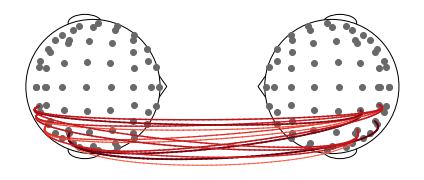

CCORR: CSD – Leader-Follower vs Control (Beta, 13.5–30 Hz)


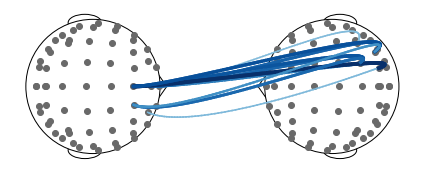

In [63]:
### Visualizing for CSD

pair_n = '005'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition = 'coupled'

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_csd_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_csd_epo.fif'), verbose=False)


print('CCORR: CSD – Actor-Observer vs Control (Alpha, 8–13 Hz)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots_test['csd_alpha_combined_ao_vs_control'], 
                         threshold=1, steps=100, lab=False)

print('CCORR: CSD – Leader-Follower vs Control (Beta, 13.5–30 Hz)')
viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                         dict_for_plots_test['csd_beta_lf_vs_control'], 
                         threshold=1, steps=100, lab=False)

plt.show()